In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv('itamplify_train.csv')
columns_to_drop = ['track_name', 'track_id', 'artists', 'album_name', 'X']
data = data.drop(columns_to_drop, axis=1)
print(data.dtypes)
print(data.head())

popularity            int64
duration_ms           int64
explicit              int64
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
track_genre          object
dtype: object
   popularity  duration_ms  explicit  danceability  energy  key  loudness  \
0          64       168000         0         0.443   0.778    0    -7.564   
1          44       318360         0         0.580   0.800    6    -7.528   
2          42       171989         0         0.805   0.746    1    -5.211   
3          46       205440         0         0.582   0.660    7    -4.988   
4          44       220800         0         0.776   0.314    2    -9.513   

   mode  speechiness  acousticness  instrumentalness  liveness  valence  \


In [3]:
print(f"time_signature: {data['time_signature'].unique()}")
print(f"key: {data['key'].unique()}")

time_signature: [5 4 3 1 0]
key: [ 0  6  1  7  2  8  9 10  4 11  5  3]


In [4]:
import torch
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from torch.utils.data import TensorDataset, DataLoader

# Identify categorical and numerical columns
categorical_columns = ['key', 'time_signature']
numerical_columns = ['popularity', 'duration_ms', 'loudness', 'tempo', 
                     'danceability', 'energy', 'speechiness', 'acousticness', 
                     'instrumentalness','liveness', 'valence']

# Create a transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(), categorical_columns)
    ])

# Prepare target mapping for genres
genres = data['track_genre'].unique()
genre_to_idx = {genre: idx for idx, genre in enumerate(genres)}
data['track_genre'] = data['track_genre'].map(genre_to_idx)

# Split the data
features = data.drop('track_genre', axis=1)
target = data['track_genre']

# Apply preprocessing
X = preprocessor.fit_transform(features)
y = target.values

# Convert arrays to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Create data loaders for batch processing
train_dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


In [5]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=0.2, 
                                                  random_state=42, 
                                                  stratify=y)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MusicGenreClassifier(nn.Module):
    def __init__(self):
        super(MusicGenreClassifier, self).__init__()
        self.fc1 = nn.Linear(X.shape[1], 512)  # Adjust the input size based on the number of features after preprocessing
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, len(genres))  # Output size is the number of genres

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc3(x)
        return x


In [10]:
model = MusicGenreClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100 

Epoch 1: Train Loss: 2.0385, Train Acc: 35.60%, Val Loss: 1.6659, Val Acc: 44.98%
Epoch 11: Train Loss: 1.4531, Train Acc: 52.40%, Val Loss: 1.4118, Val Acc: 53.02%
Epoch 21: Train Loss: 1.3319, Train Acc: 55.85%, Val Loss: 1.3513, Val Acc: 54.84%
Epoch 31: Train Loss: 1.2443, Train Acc: 58.12%, Val Loss: 1.3390, Val Acc: 55.86%
Epoch 41: Train Loss: 1.1902, Train Acc: 59.83%, Val Loss: 1.3298, Val Acc: 56.59%
Epoch 51: Train Loss: 1.1326, Train Acc: 61.65%, Val Loss: 1.3252, Val Acc: 56.23%
Epoch 61: Train Loss: 1.0969, Train Acc: 62.36%, Val Loss: 1.3350, Val Acc: 56.59%
Epoch 71: Train Loss: 1.0669, Train Acc: 62.89%, Val Loss: 1.3416, Val Acc: 56.71%
Epoch 81: Train Loss: 1.0252, Train Acc: 63.79%, Val Loss: 1.3625, Val Acc: 56.17%
Epoch 91: Train Loss: 0.9985, Train Acc: 64.75%, Val Loss: 1.3572, Val Acc: 57.07%


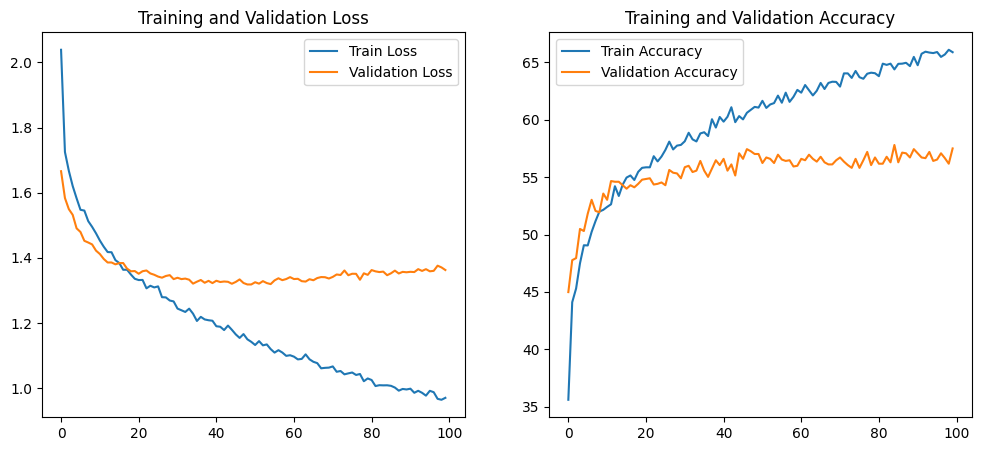

In [11]:
import matplotlib.pyplot as plt

train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_loss = 0.0
    correct = total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Send data to GPU

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_accuracy)

    # Validation Phase
    model.eval()
    val_running_loss = 0.0
    correct = total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Send data to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accs.append(val_accuracy)

    if(epoch % 10 == 0):
        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [15]:
# Create dictionaries to hold counts for each class
correct_class = {genre: 0 for genre in genres}
total_class = {genre: 0 for genre in genres}

# Validation phase with class-wise accuracy calculation
model.eval()
val_running_loss = 0.0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        for label, prediction in zip(labels, predicted):
            if label == prediction:
                correct_class[genres[label.item()]] += 1
            total_class[genres[label.item()]] += 1

val_loss = val_running_loss / len(val_loader)

# Print class-wise accuracy
class_accuracies = {genre: 100 * correct_class[genre] / total_class[genre] for genre in genres if total_class[genre] > 0}
for genre, accuracy in class_accuracies.items():
    print(f'Acc. {genre}: {accuracy:.2f}%')


Acc. afrobeat: 35.29%
Acc. alternative: 45.83%
Acc. blues: 20.00%
Acc. classical: 72.00%
Acc. country: 32.76%
Acc. disco: 53.96%
Acc. folk: 41.18%
Acc. funk: 69.84%
Acc. heavy-metal: 73.81%
Acc. hip-hop: 66.09%
Acc. jazz: 29.63%
Acc. psych-rock: 56.40%
Acc. reggaeton: 59.46%
Acc. samba: 82.05%
Acc. techno: 77.01%
